# Bob or Kendrick

Two of the great wordsmiths of the modern era. Any fan would be able discern the artist from the lyrics, but can a machine?

This notebook will look to adopt a few different methods to answer this question.

Methods:
- Sentiment-based
- Language-based

The basic version of the model will

In [195]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC

from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

import textacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tqdm

## Data Import

In [142]:
bob = pd.read_csv('bob.csv', index_col=0)
ken = pd.read_csv('kendrick.csv', index_col=0)

In [143]:
df = pd.concat([bob, ken], ignore_index=True)
del bob, ken

## Data Prep

In [129]:
def drop_breaks(lyrics):
    '''
    Strip our section marker from lyrics i.e. ['Verse 1'] and line breaks
    '''
    return re.sub(r'\[(.*?)\]', '', lyrics)

In [150]:
def remove_digits(lyrics):
    '''
    Strip our section marker from lyrics i.e. ['Verse 1'] and line breaks
    '''
    return re.sub(r'[0-9]', '', lyrics)

In [96]:
def process_text(songs, pos=False):
    '''
    Cleans sentences from stop words and punctuation and filters by pos tags if given
    returns cleaned sentence and tokenized sentence
    '''   
    nlp = textacy.load_spacy_lang('en_core_web_sm')
    
    texts, tokenised_texts = [], []
        
    if pos: 
        for lyrics in tqdm.notebook.tqdm(nlp.pipe(songs, batch_size=200)):
            assert lyrics.is_parsed
            tokens = [token
                      for token in lyrics 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for lyrics in tqdm.notebook.tqdm(nlp.pipe(songs, batch_size=200)):
            assert lyrics.is_parsed
            tokens = [token
                      for token in lyrics 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

In [298]:
df['song'] = df.song.str.replace('\n',' ')\

In [151]:
pos = ['NOUN', 'ADJ', 'VERB', 'ADV']

df['lyrics'] = df.lyrics.str.replace('\n',' ')\
                            .apply(lambda x: drop_breaks(x))\
                            .apply(lambda x: remove_digits(x))\
                            .str.lower()

processed_quotes, tokenised_quotes = process_text(df.lyrics)

df['lyrics_processed'] = processed_quotes
df['lyrics_tokenised'] = tokenised_quotes

In [155]:
df.head(2)

,artist,song,lyrics,lyrics_processed,lyrics_tokenised
0,Bob Dylan,Murder Most Foul,"it was a dark day in dallas, november ' a da...",dark day dallas november day live infamy pre...,"[ , dark, day, dallas, november, day, live, ..."
1,Bob Dylan,Blowin’ in the Wind,how many roads must a man walk down before y...,roads man walk man seas white dove sail sleeps...,"[ , roads, man, walk, man, seas, white, dove,..."


In [41]:
df['artist'].value_counts(normalize = True)

Bob Dylan         0.666667
Kendrick Lamar    0.333333
Name: artist, dtype: float64

## Data Exploration and Viz

In [245]:
def plot_confusion(cm):
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,  cmap = 'coolwarm')
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.xticks([i-0.5 for i in range(1,3)], ['Bob Dylan', 'Kendrick Lamar'])
    plt.yticks([i-0.5 for i in range(1,3)], ['Bob Dylan', 'Kendrick Lamar'])
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show()
    


In [221]:
def vectorise(ngram_range, max_feats, input_data):
    '''
    Returns non-sparse format. With a larger dataset rather return
    '''
    vect = TfidfVectorizer(ngram_range, max_features=max_feats)
    
    return pd.DataFrame(vect.fit_transform(input_data).todense(), columns=vect.get_feature_names())

In [229]:
def generate_class_weights(y):
    
    return dict(zip(list(np.unique(y)), 
                    class_weight.compute_class_weight('balanced', np.unique(y), y)))

In [231]:
class_weights = generate_class_weights(df['artist'])

In [232]:
X = vectorise(ngram_range=(1, 2), max_feats=500, input_data=df['lyrics_processed'])

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, df['artist'],
                                                    test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True,
                                                    stratify=df['artist'])

In [255]:
param_grid = {
    
    'n_estimators':[50,100,150,200,250,300],
    'max_depth':[5,7,10,15]
    
}

grid = GridSearchCV(RandomForestClassifier(random_state=1,
                                           class_weight=class_weights),
                                           param_grid,
                                           cv=5,
                                           n_jobs=2).fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

0.9458333333333333 {'max_depth': 5, 'n_estimators': 100}


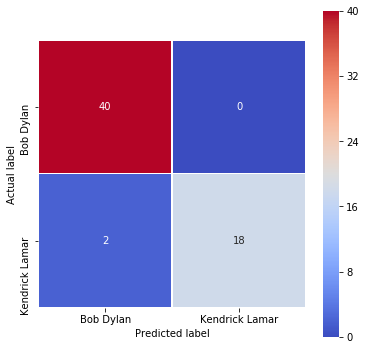

In [256]:
clf = RandomForestClassifier(random_state = 1,
                             max_depth=grid.best_params_['max_depth'],
                             n_estimators=grid.best_params_['n_estimators'],
                             class_weight=class_weights).fit(X_train, y_train)

preds = clf.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)
plot_confusion(cm_rf)

In [257]:
imps = pd.DataFrame({'importance':clf.feature_importances_,
                     'feature':X_train.columns})

In [260]:
imps.sort_values('importance').tail(10)

,importance,feature
57,0.018822,cause
108,0.020923,em
167,0.022045,got
493,0.023069,yeah
148,0.023617,fuck
2,0.031969,ai
25,0.053877,bitch
371,0.059476,shit
462,0.061240,wanna
296,0.065099,nigga


In [271]:
results = pd.DataFrame({'actual':y_test,
              'predicted':preds
             }, index=y_test.index)

results['lyrics'], results['song'] = df['lyrics'], df['song']

In [274]:
mistakes = results[results['actual']!=results['predicted']]

In [299]:
for key, value in dict(zip(list(mistakes['song'].values), list(mistakes['lyrics'].values))).items():
    print('Song: ' + key)
    print('   ')
    print(value)
    print('  ')

Song: Black Panther
   
  (why i go easy?) (know why i go easy) wait    king of my city, king of my country, king of my homeland king of the filthy, king of the fallen, we livin' again king of the shooters, looters, boosters, and ghettos poppin' king of the past, present, future, my ancestors watchin' king of the culture, king of the soldiers, king of the bloodshed king of the wisdom, king of the ocean, king of the respect king of the optimistics and dreamers that go and get it king of the winner's district and geniuses with conviction king of the fighters, king of the fathers, king of the belated king of the answer, king of the problem, king of the forsaken king of the empathy, you resent me, king of remorse king of my enemies, may they fall defeat, i rejoice king of the skyscrapers, dodgin' haters, broke religion    nine faces, go against 'em, i erased 'em with precision i embrace them with collision, kings did it king's vision, black panther, king kendrick, all hail the king! i drop

In [247]:
print(classification_report(y_test, preds))

                precision    recall  f1-score   support

     Bob Dylan       0.95      1.00      0.98        40
Kendrick Lamar       1.00      0.90      0.95        20

     micro avg       0.97      0.97      0.97        60
     macro avg       0.98      0.95      0.96        60
  weighted avg       0.97      0.97      0.97        60



## Model Optimised for Classifying Song

## Model Optimised for Classifying Lyric

In [296]:
def gather_lyric():

    lyric=input('Try your lyric here: ')
    
    return lyric

In [297]:
gather_lyric()

Try your lyric here:Dog


'Dog'